Name: Suman Roy

Roll Number: MDS202041

NLP Assignment 04

In [ ]:
#importing necessary libraries
import os
from tqdm import tqdm
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load necessary libraries to build word vectors
import gensim
from gensim.models import word2vec
import logging

## A. Preprocessing

We have already preprocessed the corpus in our first assignment. Here I am going to use that corpus only. The preprocessing steps included:
**A. Discarding Non English documents from the corpus**

**B. Using Regex patterns**

1.   Expanding words with ' (like you're, I'm etc. )   
2.   Removing all digits(as we are building a text corpus). 
3.   Removing foreign/non-ASCII characters. 
4.   Removing parenthesis and texts inside parenthesis(Assuming that those texts are extra information). Citations are inside third brackets. 
5.  Removing html addresses.
6.  Removing email addresses.
7.  Removing punctuations. 
8.  Removing single alphabets except 'a' (like 'q', 'b' etc.) because they are either meaningless or part of some mathematical expression. 
9.  Removing extra white spaces. 

**C. Stopwords Removal**

**D. Lemmatization**


## B. Build Word vectors

In [ ]:
#function to compute word vector given preprocessed corpus
def compute_word_vectors(): 
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    text = word2vec.Text8Corpus('/content/drive/MyDrive/CMI/Semester 4/NLP/Assignment 1/corpus_english_lemma.txt')
    model = word2vec.Word2Vec(text, size=128, window=5, min_count=50, workers=10, iter=10)
    model.save('/content/drive/MyDrive/CMI/Semester 4/NLP/Assignment 4/text8.model.bin')
    return model

In [ ]:
#building model
model = compute_word_vectors()

2022-04-24 14:24:32,647 : INFO : collecting all words and their counts
2022-04-24 14:24:32,728 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-04-24 14:25:04,482 : INFO : PROGRESS: at sentence #10000, processed 100000000 words, keeping 594058 word types
2022-04-24 14:25:09,050 : INFO : collected 646051 word types from a corpus of 114266307 raw words and 11427 sentences
2022-04-24 14:25:09,052 : INFO : Loading a fresh vocabulary
2022-04-24 14:25:09,520 : INFO : effective_min_count=50 retains 45095 unique words (6% of original 646051, drops 600956)
2022-04-24 14:25:09,524 : INFO : effective_min_count=50 leaves 111829684 word corpus (97% of original 114266307, drops 2436623)
2022-04-24 14:25:09,690 : INFO : deleting the raw counts dictionary of 646051 items
2022-04-24 14:25:09,721 : INFO : sample=0.001 downsamples 20 most-common words
2022-04-24 14:25:09,722 : INFO : downsampling leaves estimated 109539117 word corpus (98.0% of prior 111829684)
2022-04-24 1

In [ ]:
model = word2vec.Word2Vec.load("/content/drive/MyDrive/CMI/Semester 4/NLP/Assignment 4/text8.model.bin") #loading the model

## C. Selection of keywords

In [ ]:
# function to compute similar words 
def compute_similar_words(model,source_word, topn=5):
    print('\r Computing similar words for the source word - {0}'.format(source_word),end='')
    similar_words = [source_word]
    try:
        top_words = model.wv.most_similar(source_word,topn=topn)
        similar_words.extend([val[0] for val in top_words])
    except KeyError as err:
        print(err.args)
    return similar_words

In [ ]:
#funcion to find similar words at 3 levels. I tried for similar words at 4 level deep but the graph is getting clumsy so I am keeping calculating similar words at level 3.
def find_similar_words():
    columns = ['word'+str(i-1) for i in range(1,7)]
    df = pd.DataFrame(data=None,columns=columns)

    #Keywords contains the list of keywords from the vocabulary. 
    #These keywords are used to find similar words 

    for source_word in keywords:
        similar_words = compute_similar_words(model,source_word)
        df.loc[len(df)] = similar_words
        
        for i in range(1,len(similar_words)):
            sec_similar_words = compute_similar_words(model,similar_words[i])
            df.loc[len(df)] = sec_similar_words

            for j in range(1, len(sec_similar_words)):
              third_similar_words = compute_similar_words(model, sec_similar_words[j])
              df.loc[len(df)] = third_similar_words


    #Save similar words to a file. This file will be used to build the graph
    return df

In [ ]:
keywords = ['health','risk','research','economic','twitter','mask','bat','test','trial','outbreak']
df = find_similar_words()

 Computing similar words for the source word - resurgence

In [ ]:
df

,word0,word1,word2,word3,word4,word5
0,health,heath,healthcare,outcry,medical,wellbeing
1,heath,health,outcry,healthcare,entrust,osh
2,health,heath,healthcare,outcry,medical,wellbeing
3,outcry,broadcaster,distrust,discontent,health,heath
4,healthcare,health,care,frontline,medical,caring
...,...,...,...,...,...,...
212,sinicus,rhinolophus,ferrumequinum,affinis,ricketti,pusillus
213,ferrumequinum,rhinolophus,sinicus,pusillus,fuliginosus,ricketti
214,miniopterus,pipistrellus,hipposideros,ricketti,rhinolophus,pusillus
215,rousettus,rhinolophus,pteropus,hipposideros,aegyptiacus,miniopterus


## D. Building Knowledge Graph

In [ ]:
#color of each keyword
cmap_components = {
                    'health': 'gray',
                    'risk' : 'royalblue',
                    'research': 'lightsteelblue',
                    'economic' : 'green',
                    'twitter': 'pink',
                    'mask': 'brown',
                    'bat' :'red',
                    'test' : 'yellow',
                    'trial': 'cyan',
                    'outbreak': 'black'
                                       
                   }

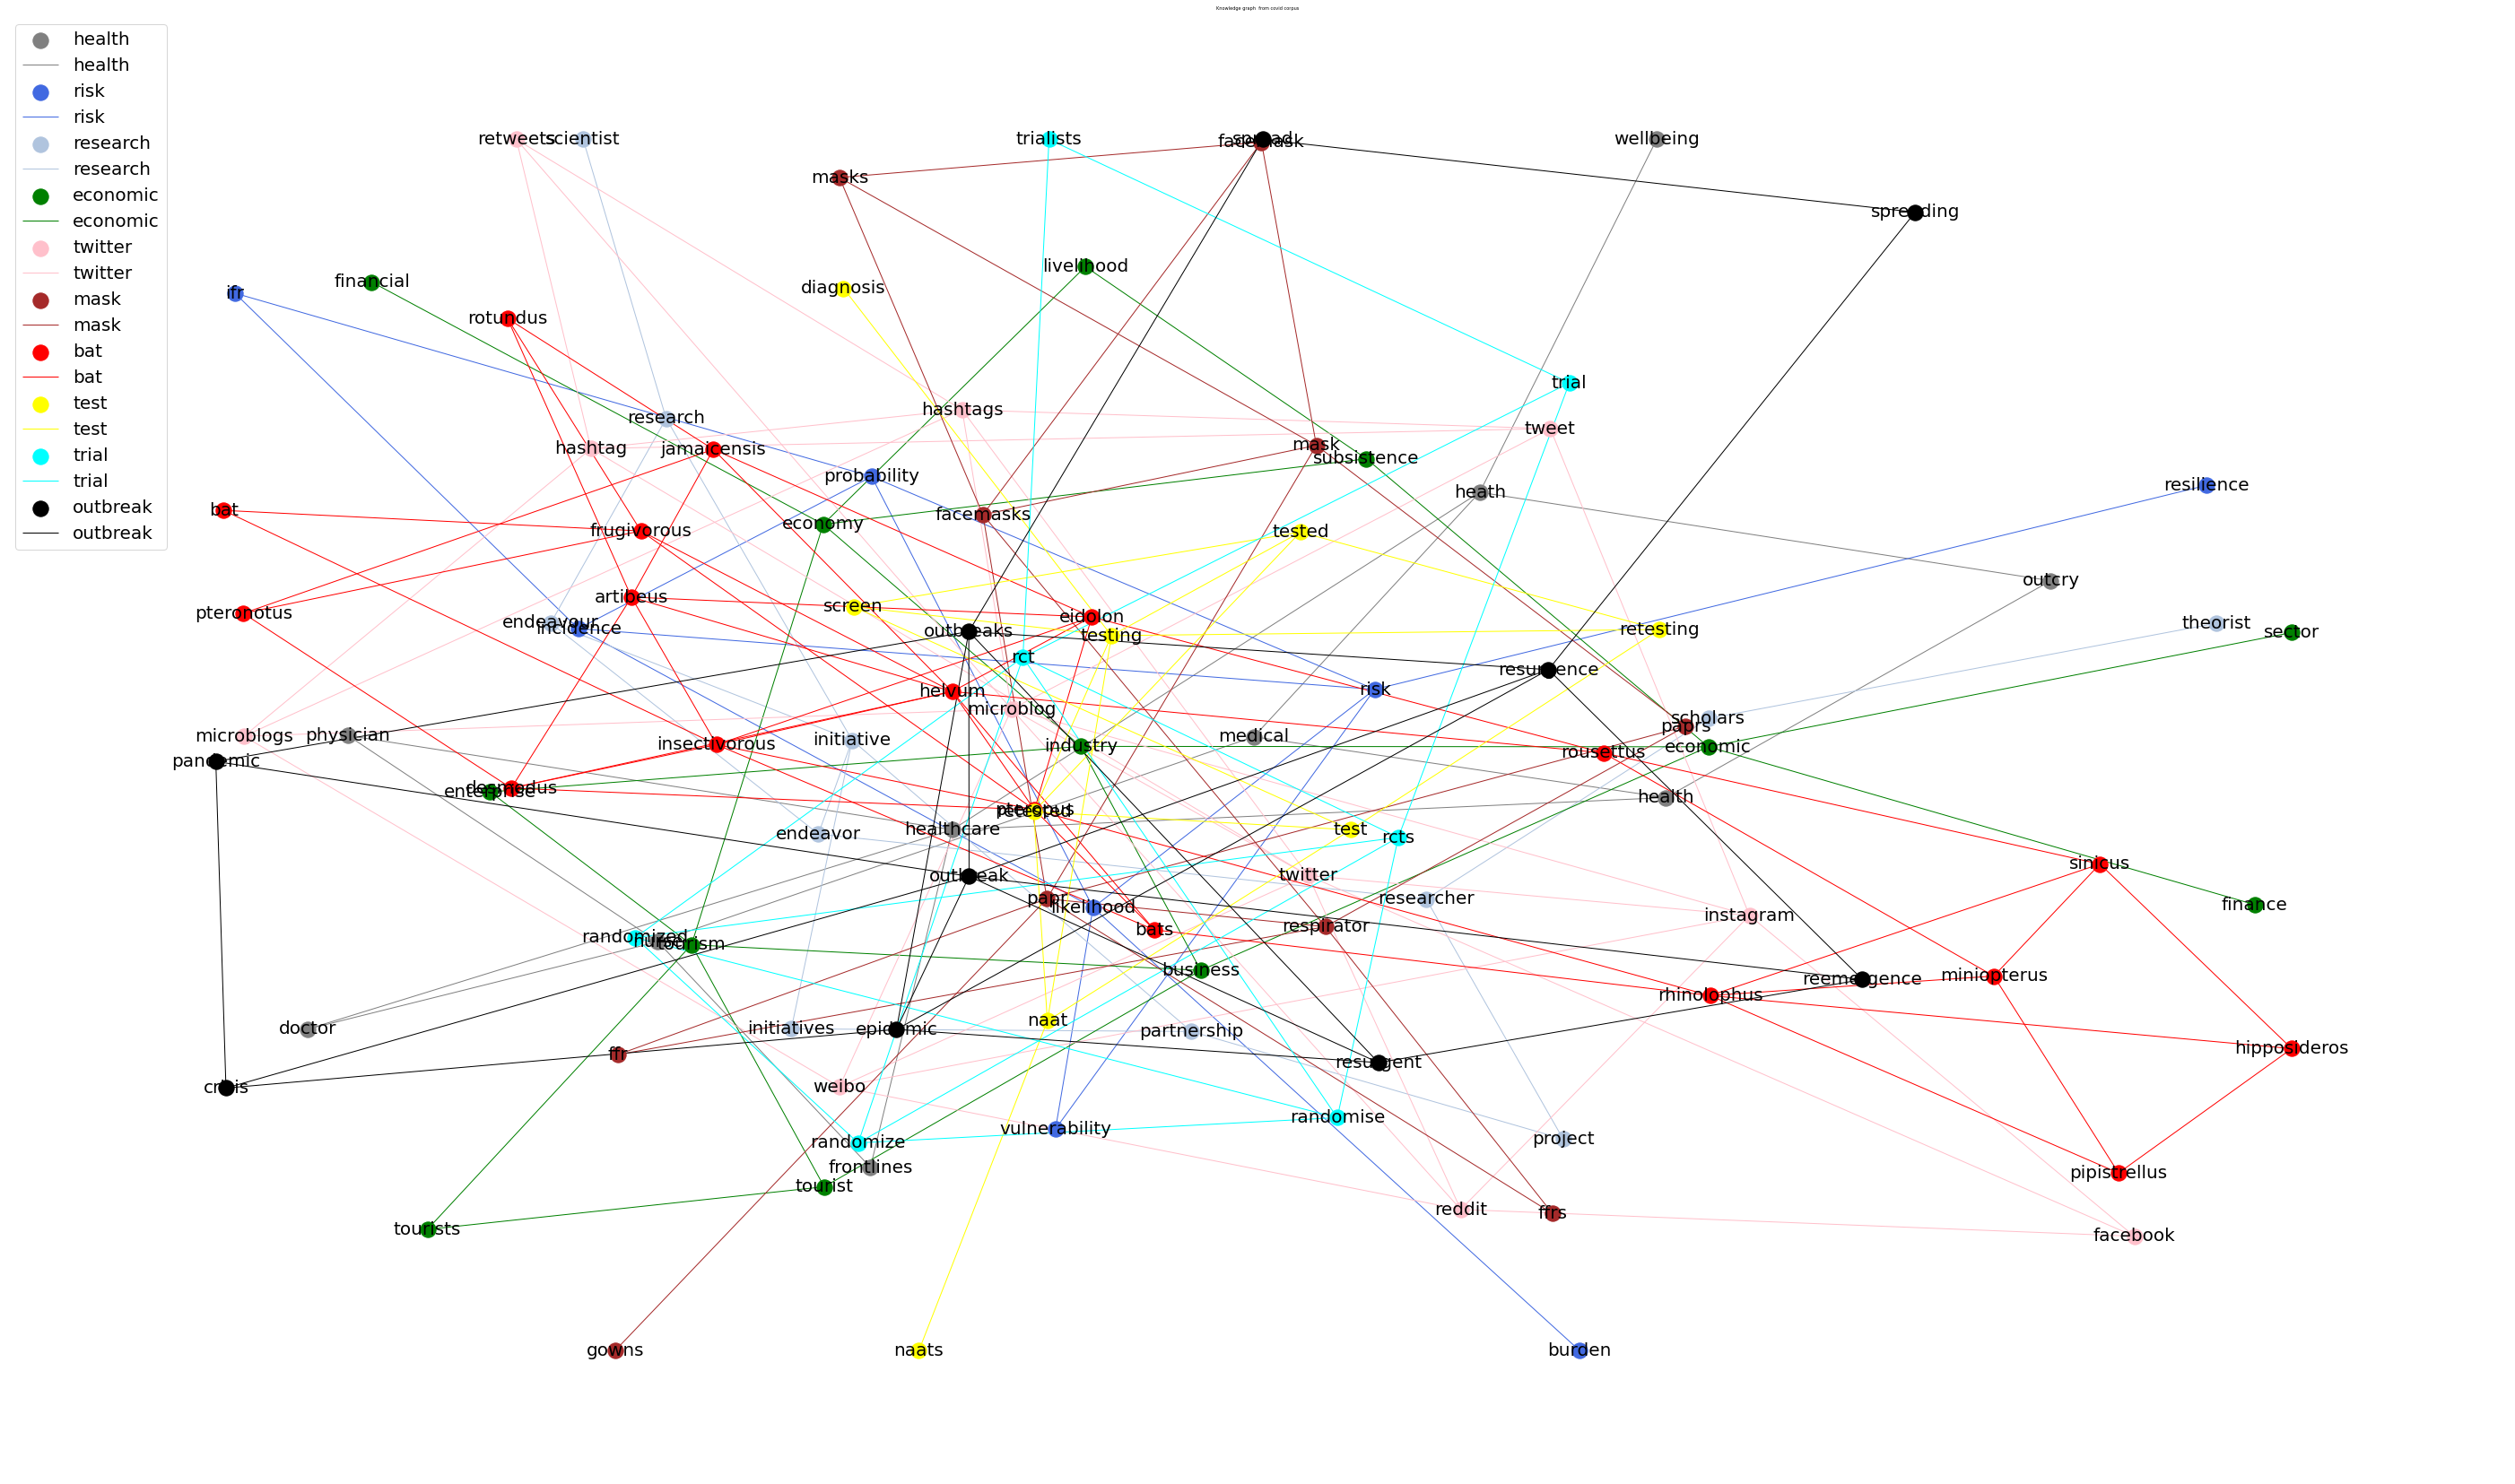

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

words = df

g = nx.cubical_graph()

#Construct the graph
#for every source word(node), add edges - connected through similarity
#As there two levels of similar words, we need to repeat the same to construct the graph
for i, row in words.iterrows():
    for j in range(1,len(row)):
        g.add_node(row[j])
    for j in range(2,len(row)):
        g.add_edge(row[1], row[j])    
      
G = nx.petersen_graph()
plt.subplot()
options = {
    #'node_color': 'blue',
    #'node_size': 8,
    #'linewidths': 0.3,
    #'width': 0.5,
    'font_size':20,
}

fedges = filter(lambda x: g.degree()[x[0]] >= 3 and g.degree()[x[1]] >= 5, g.edges())
f = nx.Graph()                                                                                                                                     
f.add_edges_from(fedges)

#This is to show how well the keyword is connected with the other words in the corpus  
#change the keyword to obtain a different graph
#you do not need this while running the entire no

plt.rcParams['figure.figsize'] = [50,30]

for keyword in keywords:
  subgraph = nx.node_connected_component(f,keyword)
  nx.draw(g.subgraph(subgraph), with_labels=True,**options, edge_color = cmap_components[keyword], node_color = cmap_components[keyword], label = keyword)

plt.legend(loc = 'upper left', fontsize = 'medium', prop={'size': 20})
plt.title("Knowledge graph  from covid corpus", fontsize = 5)
plt.savefig('/content/drive/MyDrive/CMI/Semester 4/NLP/Assignment 4/graph.pdf')
plt.show()

I have also shown the individual graphs of the keywords one by one for better understanding. 

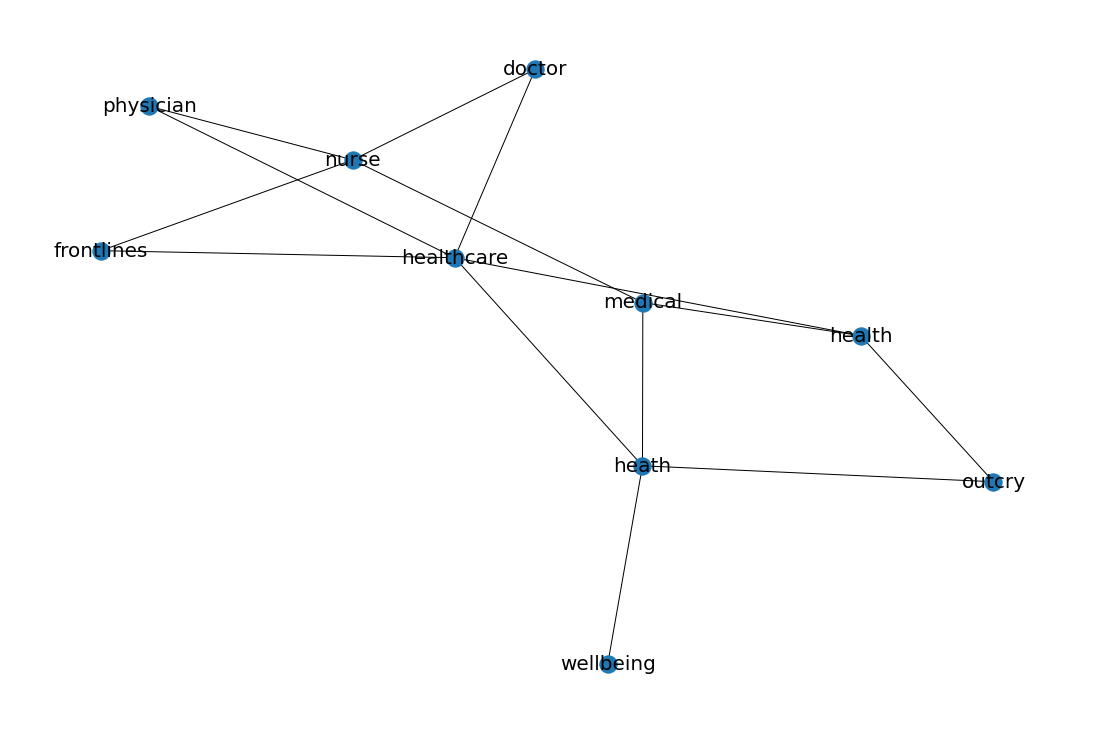

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]
subgraph = nx.node_connected_component(f,'health')
nx.draw(g.subgraph(subgraph), with_labels=True, font_size = 20)

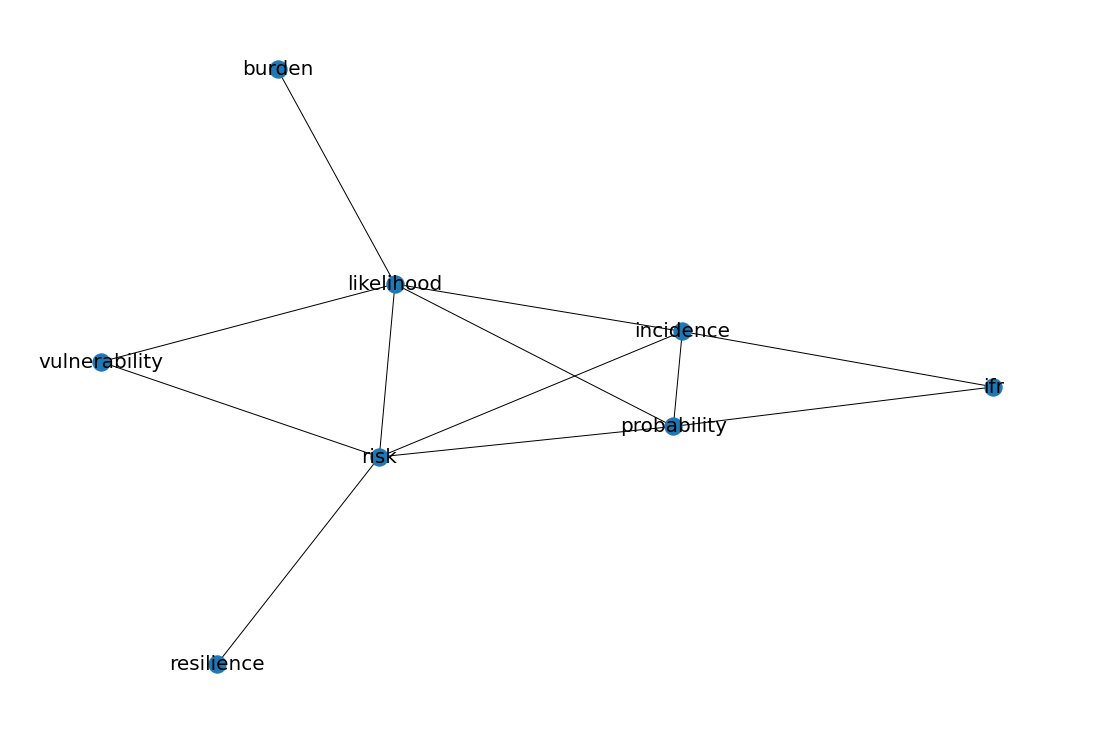

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]
subgraph = nx.node_connected_component(f,'risk')
nx.draw(g.subgraph(subgraph), with_labels=True, font_size = 20)

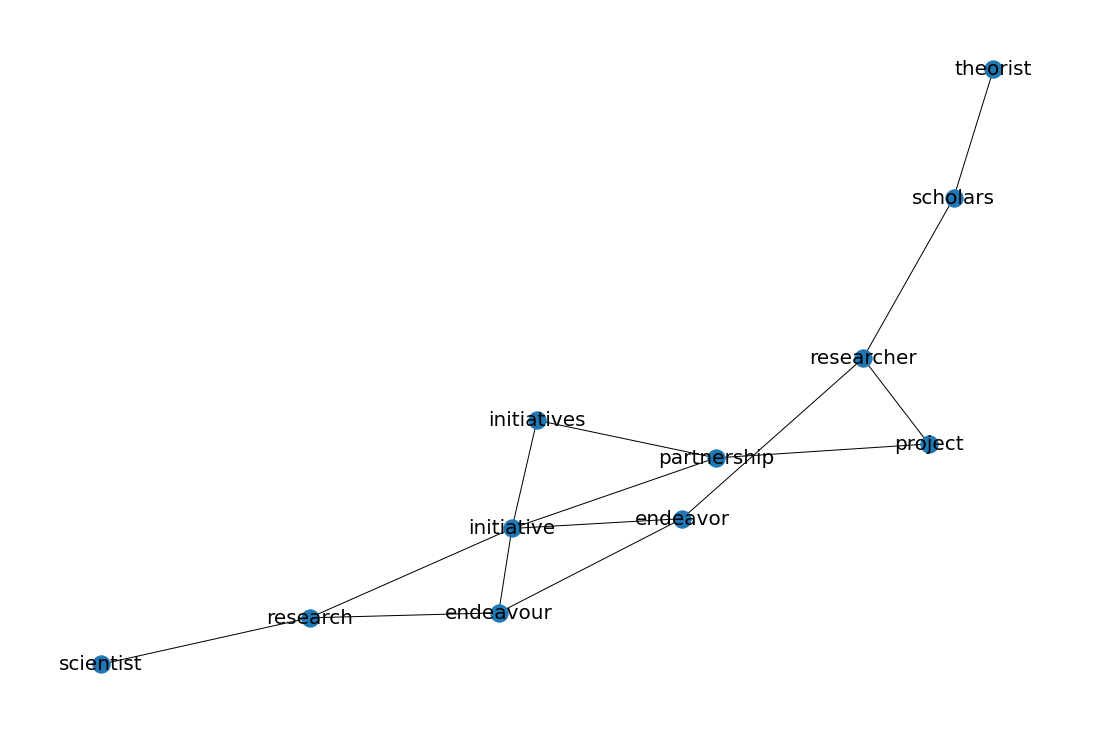

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]
subgraph = nx.node_connected_component(f,'research')
nx.draw(g.subgraph(subgraph), with_labels=True, font_size = 20)

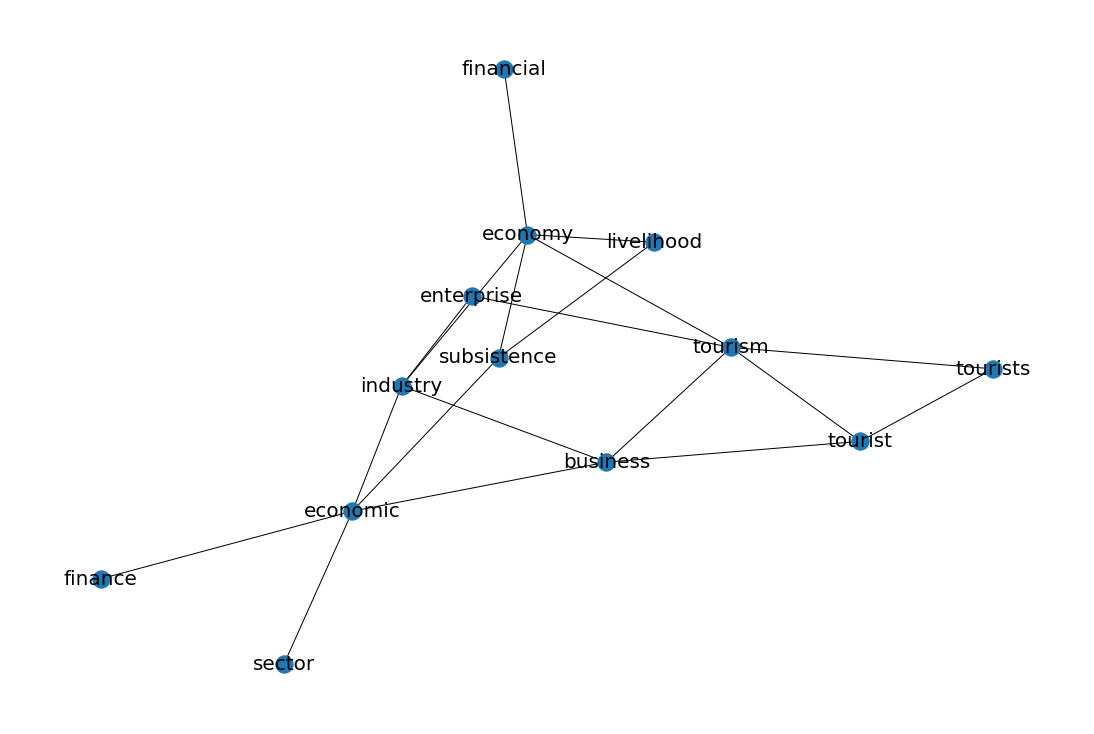

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]
subgraph = nx.node_connected_component(f,'economic')
nx.draw(g.subgraph(subgraph), with_labels=True, font_size = 20)

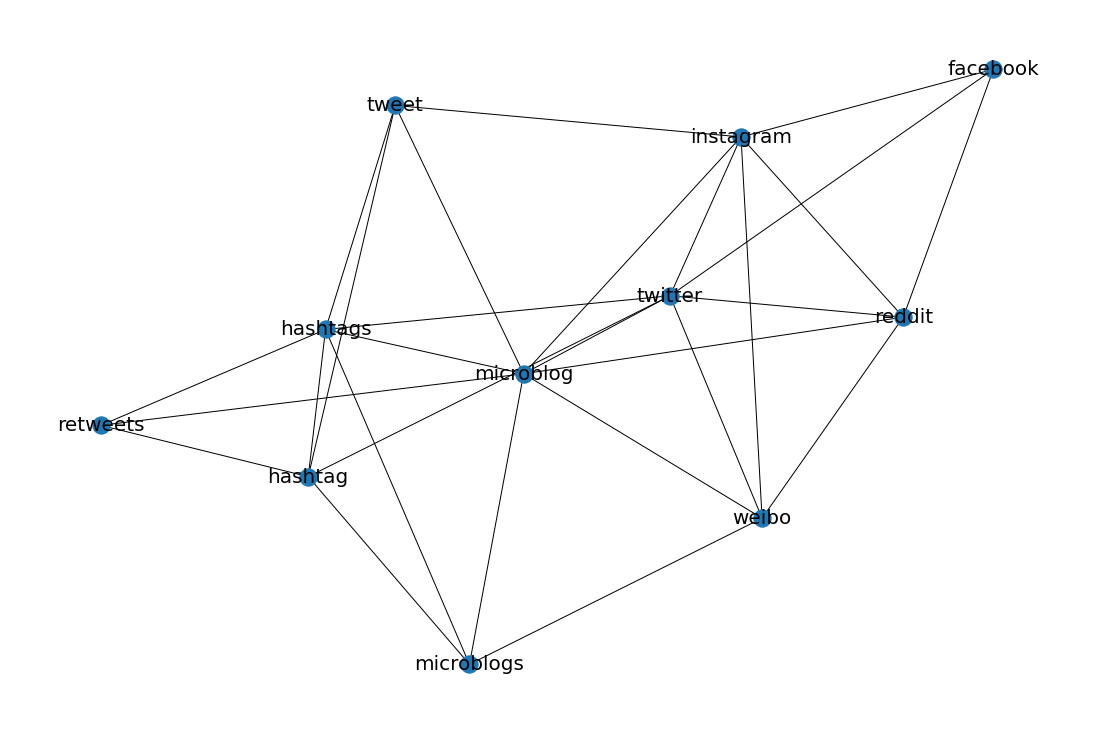

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]
subgraph = nx.node_connected_component(f,'twitter')
nx.draw(g.subgraph(subgraph), with_labels=True, font_size = 20)

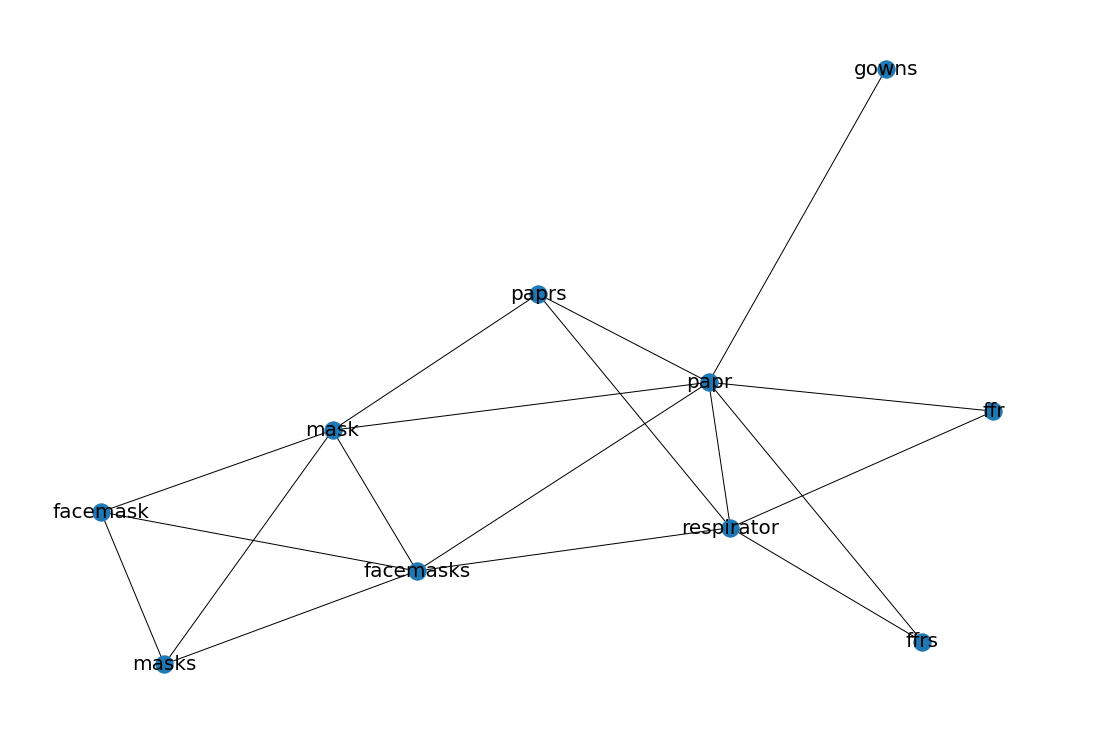

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]
subgraph = nx.node_connected_component(f,'mask')
nx.draw(g.subgraph(subgraph), with_labels=True, font_size = 20)

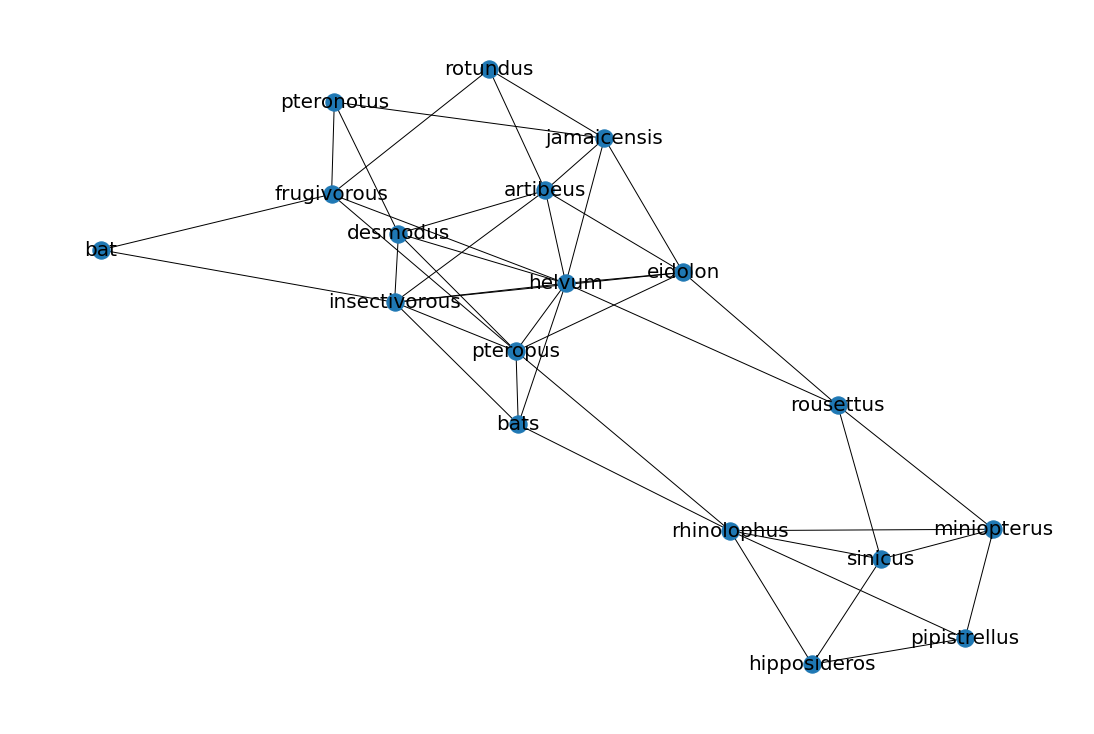

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]
subgraph = nx.node_connected_component(f,'bat')
nx.draw(g.subgraph(subgraph), with_labels=True, font_size = 20)

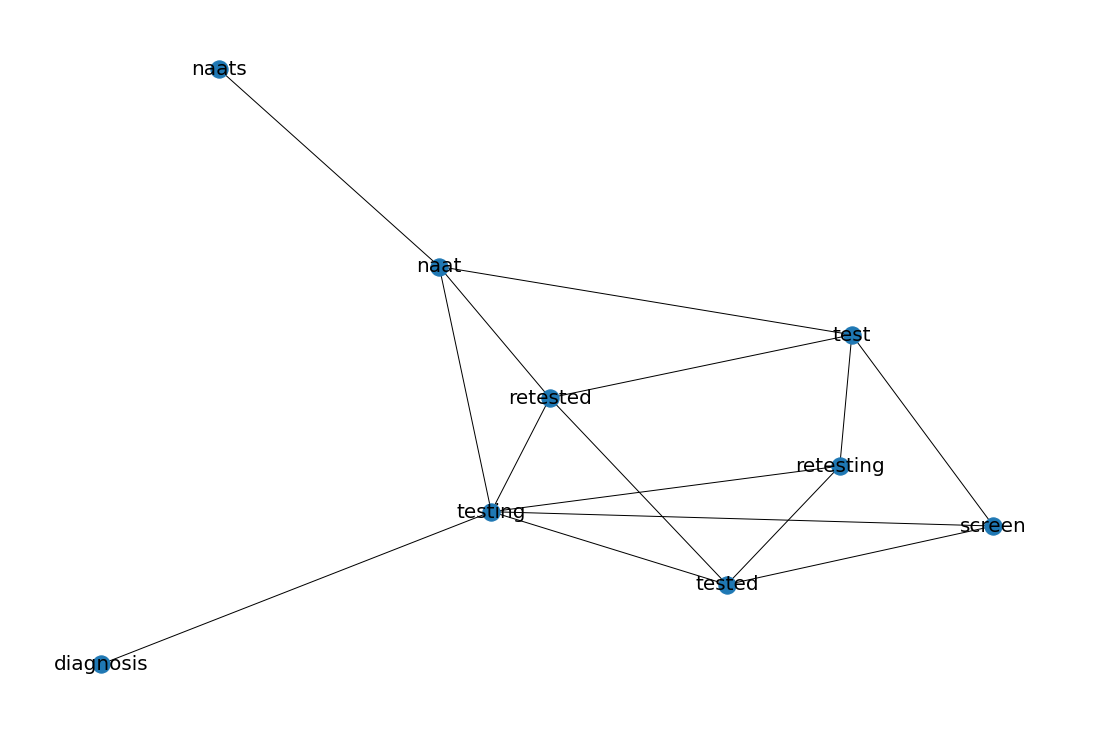

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]
subgraph = nx.node_connected_component(f,'test')
nx.draw(g.subgraph(subgraph), with_labels=True, font_size = 20)

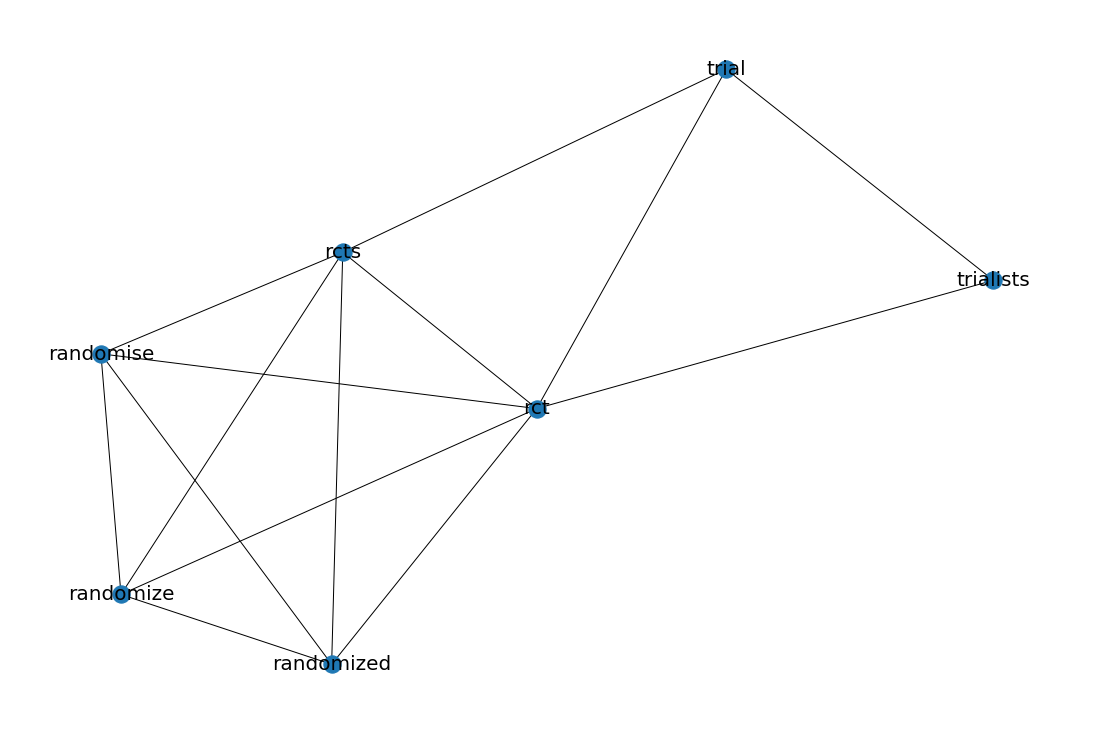

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]
subgraph = nx.node_connected_component(f,'trial')
nx.draw(g.subgraph(subgraph), with_labels=True, font_size = 20)

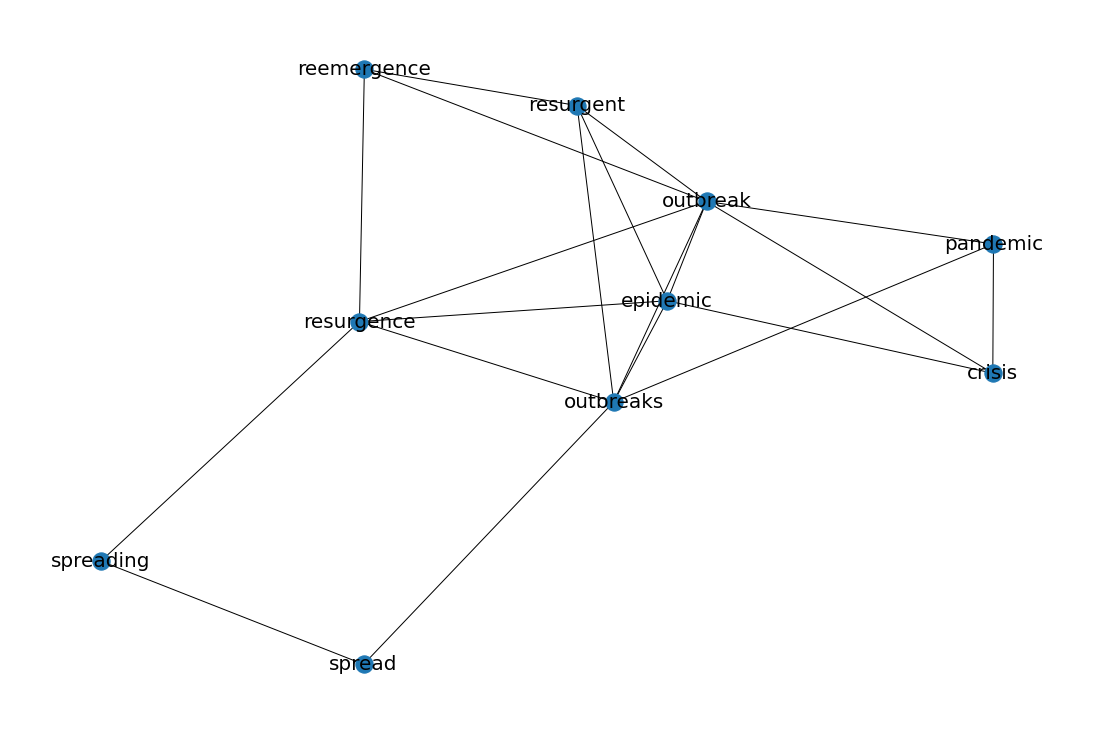

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]
subgraph = nx.node_connected_component(f,'outbreak')
nx.draw(g.subgraph(subgraph), with_labels=True, font_size = 20)